<a href="https://colab.research.google.com/github/Jathin4/DocuSearch-AI-Semantic-PDF-Search-with-Visual-and-Tabular-Insights/blob/main/DocuSearch_AI_Semantic_PDF_Search_with_Visual_and_Tabular_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install PyMuPDF
!pip install PyMuPDF nltk spacy transformers scikit-learn numpy
!pip install faiss-cpu transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 71.3 MB/s eta 0:00:00


Enter the path to your PDF file: /content/CompTIA-Network-N10-007-Cert-Guide.pdf
Processing PDF: /content/CompTIA-Network-N10-007-Cert-Guide.pdf
Processed 806 text chunks from 842 pages
Creating embeddings...
Embeddings created and indexed

Enter your search query (or 'exit' to quit): different types of topology



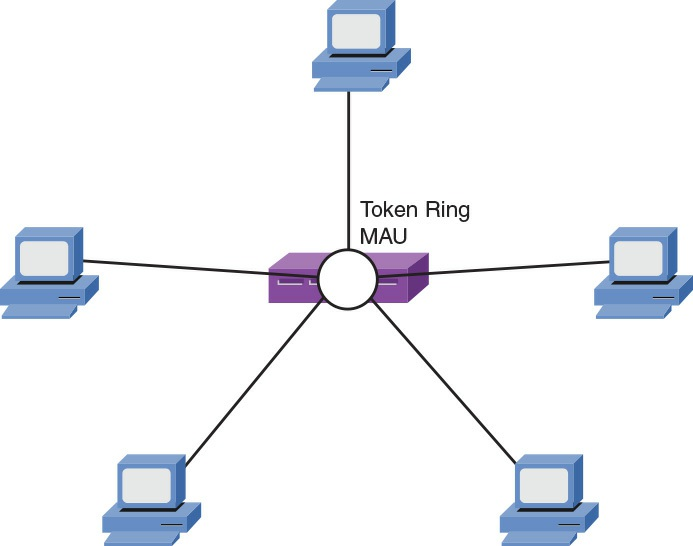
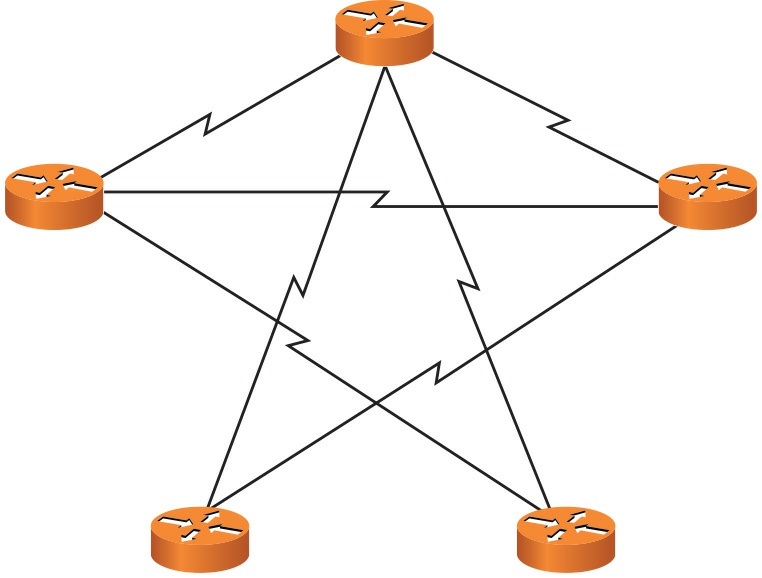
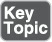
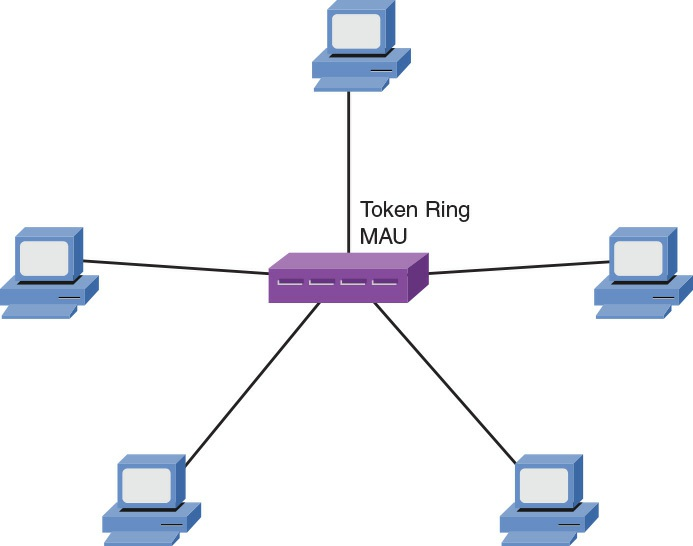


Enter your search query (or 'exit' to quit): exit


In [5]:
import os
import fitz  # PyMuPDF
import nltk
import numpy as np
import faiss
import torch
from transformers import AutoTokenizer, AutoModel
import base64
from typing import Dict, List, Tuple
from dataclasses import dataclass
from IPython.display import display, HTML

@dataclass
class PageContent:
    text: str
    images: List[str]  # Base64 encoded images
    tables: List[str]  # HTML tables

class PDFSearchEngine:
    def __init__(self, pdf_path: str):
        self.pdf_path = pdf_path
        self.page_contents: Dict[int, PageContent] = {}
        self.chunks: List[Tuple[str, int]] = []  # (text_chunk, page_number)
        self.embeddings = None
        self.faiss_index = None

        # Initialize transformer model
        model_name = "sentence-transformers/all-MiniLM-L6-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        # Download required NLTK data
        nltk.download('punkt', quiet=True)

        # Process the PDF
        self._process_pdf()
        self._create_embeddings()

    def _extract_images(self, page, page_num: int) -> List[str]:
        """Extract images from a page and convert them to base64."""
        images = []
        for img_index, img in enumerate(page.get_images(full=True)):
            try:
                xref = img[0]
                base_image = page.parent.extract_image(xref)
                image_bytes = base_image["image"]
                image_ext = base_image["ext"]

                # Convert to base64
                encoded = base64.b64encode(image_bytes).decode('utf-8')
                img_html = f'<img src="data:image/{image_ext};base64,{encoded}" style="max-width:400px; margin:10px 0;">'
                images.append(img_html)
            except Exception as e:
                print(f"Warning: Could not process image {img_index} on page {page_num}: {e}")
        return images

    def _extract_tables(self, page) -> List[str]:
        """Extract tables from a page and convert them to HTML."""
        tables = []
        blocks = page.get_text("dict")["blocks"]

        for block in blocks:
            if block['type'] == 0:  # Text block
                rows = []
                for line in block["lines"]:
                    cells = [span["text"].strip() for span in line["spans"]]
                    if any(cells):  # If there's any text in the row
                        rows.append(cells)

                if len(rows) > 1 and any(len(row) > 1 for row in rows):  # Likely a table
                    table_html = '<table border="1" style="border-collapse:collapse; margin:10px 0;">'
                    for row in rows:
                        table_html += "<tr>" + "".join(f"<td style='padding:5px'>{cell}</td>" for cell in row) + "</tr>"
                    table_html += "</table>"
                    tables.append(table_html)

        return tables

    def _process_pdf(self):
        """Process the PDF and extract text, images, and tables."""
        print(f"Processing PDF: {self.pdf_path}")
        doc = fitz.open(self.pdf_path)

        for page_num in range(len(doc)):
            page = doc[page_num]

            # Extract content
            text = page.get_text("text")
            images = self._extract_images(page, page_num)
            tables = self._extract_tables(page)

            # Store page content
            self.page_contents[page_num] = PageContent(text, images, tables)

            # Create chunks (using simple paragraph splitting for this example)
            paragraphs = text.split('\n\n')
            for para in paragraphs:
                if len(para.strip()) > 50:  # Only keep substantial paragraphs
                    self.chunks.append((para.strip(), page_num))

        doc.close()
        print(f"Processed {len(self.chunks)} text chunks from {len(self.page_contents)} pages")

    def _create_embeddings(self):
        """Create embeddings for all text chunks."""
        print("Creating embeddings...")
        embeddings = []

        for chunk, _ in self.chunks:
            inputs = self.tokenizer(chunk, return_tensors='pt', truncation=True, max_length=512, padding=True)
            with torch.no_grad():
                outputs = self.model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).numpy()
            embeddings.append(embedding)

        self.embeddings = np.vstack(embeddings)

        # Create FAISS index
        dimension = self.embeddings.shape[1]
        self.faiss_index = faiss.IndexFlatL2(dimension)
        self.faiss_index.add(self.embeddings.astype(np.float32))
        print("Embeddings created and indexed")

    def search(self, query: str, top_k: int = 3) -> str:
        """Search the PDF content and return formatted results."""
        # Create query embedding
        inputs = self.tokenizer(query, return_tensors='pt', truncation=True, max_length=512, padding=True)
        with torch.no_grad():
            query_embedding = self.model(**inputs).last_hidden_state.mean(dim=1).numpy()

        # Search
        distances, indices = self.faiss_index.search(query_embedding.astype(np.float32), top_k)

        # Format results
        results_html = f"""
        <div style='font-family: Arial, sans-serif;'>
            <h2 style='color: #2c3e50;'>Search Results for: "{query}"</h2>
        """

        seen_pages = set()
        for i, idx in enumerate(indices[0]):
            if idx >= 0 and idx < len(self.chunks):
                chunk_text, page_num = self.chunks[idx]
                similarity = 1 / (1 + distances[0][i])

                results_html += f"""
                <div style='margin: 20px 0; padding: 15px; border: 1px solid #e0e0e0; border-radius: 5px;'>
                    <h3 style='color: #34495e;'>Result {i+1} (Page {page_num + 1}, Relevance: {similarity:.2f})</h3>
                    <div style='background: #f8f9fa; padding: 10px; border-radius: 3px; margin: 10px 0;'>
                        {chunk_text}
                    </div>
                """

                # Add images and tables from the page if we haven't shown them yet
                if page_num not in seen_pages:
                    page_content = self.page_contents[page_num]

                    if page_content.images:
                        results_html += f"""
                        <div style='margin-top: 15px;'>
                            <h4 style='color: #34495e;'>Related Images from Page {page_num + 1}:</h4>
                            {''.join(page_content.images)}
                        </div>
                        """

                    if page_content.tables:
                        results_html += f"""
                        <div style='margin-top: 15px;'>
                            <h4 style='color: #34495e;'>Related Tables from Page {page_num + 1}:</h4>
                            {''.join(page_content.tables)}
                        </div>
                        """

                    seen_pages.add(page_num)

                results_html += "</div>"

        results_html += "</div>"
        return results_html

def main():
    # Example usage
    pdf_path = input("Enter the path to your PDF file: ")

    try:
        # Initialize the search engine
        search_engine = PDFSearchEngine(pdf_path)

        # Interactive search loop
        while True:
            query = input("\nEnter your search query (or 'exit' to quit): ").strip()
            if query.lower() == 'exit':
                break
            if query:
                results = search_engine.search(query)
                display(HTML(results))
            else:
                print("Please enter a valid query.")

    except FileNotFoundError:
        print(f"Error: The file '{pdf_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()